## Search PatCID with Molecule Query

This notebook illustrates how to retrieve patents referencing a molecule of interest. The schema of the dataset is detailed [here]().

#### 1. Import dependencies

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

import ast
import os
import subprocess
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import mols2grid
from pdf2image import convert_from_path
from src.display import display_molecules_locations

#### 2. Search molecule

CC1(CO)CC1CC1CC2CC2(C)C1(C)C


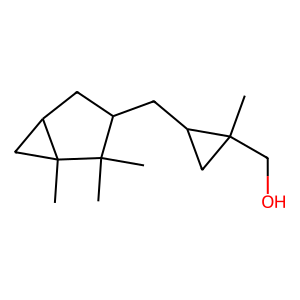

In [2]:
# Define a query SMILES
query_smiles = "CC1(C)C2(C)CC2CC1CC1C(CO)(C)C1"
# Canonicalize SMILES
molecule = Chem.MolFromSmiles(query_smiles)
Chem.RemoveStereochemistry(molecule) # Chirality is not present in PatCID
query_smiles = Chem.MolToSmiles(molecule, kekuleSmiles=False)
# Display molecule
print(query_smiles)
Draw.MolToImage(molecule)

In [3]:
# Search SMILES in PatCID (Based on this naive approach a search takes order-of-magnitude 10 seconds.)
patcid_path = os.getcwd() + f"/../data/patcid/patcid_molecule_to_patents.jsonl"

# Escape special characters
query_smiles = query_smiles.replace("[", "\[").replace("]", "\]")

process = subprocess.Popen([f"/usr/bin/grep -Rnw {patcid_path} -e '\"{query_smiles}\"'"], shell = True, stdout=subprocess.PIPE)
try:
    smiles_entry, errors = process.communicate(timeout=500)
except subprocess.TimeoutExpired:
    print("Request timeout.")
if (errors != None):
    print("Request error.")
if (smiles_entry == b""):
    print(f"{query_smiles} not found in PatCID.")
else:
    print(f"{query_smiles} found in PatCID.")
    smiles_entry = ast.literal_eval(":".join(smiles_entry.decode("utf-8").split(":")[1:]))

CC1(CO)CC1CC1CC2CC2(C)C1(C)C found in PatCID.


#### 3. Display patents referencing the molecule

In [4]:
print("Retrieved patents:")
pd.DataFrame({"patent": [p["id"] for p in smiles_entry["patents"]]})

Retrieved patents:


,patent
0,EP19731151B1
1,EP19731151
2,EP16833867B1
3,EP16833867
4,US20080275256A1
5,US20080275256
6,US20110124924A1
7,US20110124924
8,US20100284944A1
9,US20100284944


In [5]:
# Save patent identifiers
pd.DataFrame({"patent": [p["id"] for p in smiles_entry["patents"]]}).to_csv(f"patents_{query_smiles}.csv")

#### 4. Display molecules locations

Patent PDF documents can be downloaded from the patent offices websites: [USPTO](https://ppubs.uspto.gov/pubwebapp/static/pages/ppubsbasic.html), [JPO](https://www.j-platpat.inpit.go.jp/p0000), [CNIPA](https://pss-system.cponline.cnipa.gov.cn/conventionalSearchEn), [EPO](https://worldwide.espacenet.com/singleLineSearch?locale=en_EP), [KIPO](http://engpat.kipris.or.kr/engpat/searchLogina.do?next=MainSearch#page1).

The downloaded documents should then be placed in `./data/pdfs/`.

In [6]:
# Select one of the retrieved patents 
query_patent = "US20220071921A1" # EP16833867B1, EP19731151B1, US20220071921A1, US20100284944A1

In [7]:
office = "uspto" if (query_patent[:2] == "US") \
    else "jpo" if (query_patent[:2] == "JP") \
    else "cnipa" if (query_patent[:2] == "CN") \
    else "epo" if (query_patent[:2] == "EP") \
    else "kipo" 

patcid_path = os.getcwd() + f"/../data/patcid/patcid_patent_to_molecules_{office}.jsonl"
process = subprocess.Popen([f"/usr/bin/grep -Rnw {patcid_path} -e {query_patent}"], shell = True, stdout=subprocess.PIPE)
try:
    patent_entry, errors = process.communicate(timeout=500)
except subprocess.TimeoutExpired:
    print("Request timeout.")
if (errors != None):
    print("Request error.")
if (patent_entry == b""):
    print(f"{query_patent} not found in PatCID.")
else:
    if len(patent_entry.decode("utf-8").split("\n")[:-1]) > 1:
        identifiers = [ast.literal_eval(":".join(p.split(":")[1:]))["patent"]["identifiers"] for p in patent_entry.decode("utf-8").split("\n")[:-1]]
        print(f"Multiple patent identifiers were matched: {identifiers}. Please re-run the query to make sure to match only one patent (for instance, adding its kindcode).")
    else:
        print(f"{query_patent} found in PatCID.")
        patent_entry = ast.literal_eval(":".join(patent_entry.decode("utf-8").split(":")[1:]))

US20220071921A1 found in PatCID.


Display page from which the query molecule was retrieved.

Molecules in page 5
0: CC1=CCC(CCC(C)C(C)O)C1(C)C
*1: CC1(CO)CC1CC1CC2CC2(C)C1(C)C*
2: CC1=CCC(C=CC(C)C(C)O)C1(C)C
3: CC1=CCC(CCC(C)CO)C1(C)C
4: CCC(=CCC1CC=C(C)C1(C)C)CO
5: CC(=CCC1CC=C(C)C1(C)C)CO
6: CC1=CCC(C=CC(C)(C)C(C)O)C1(C)C


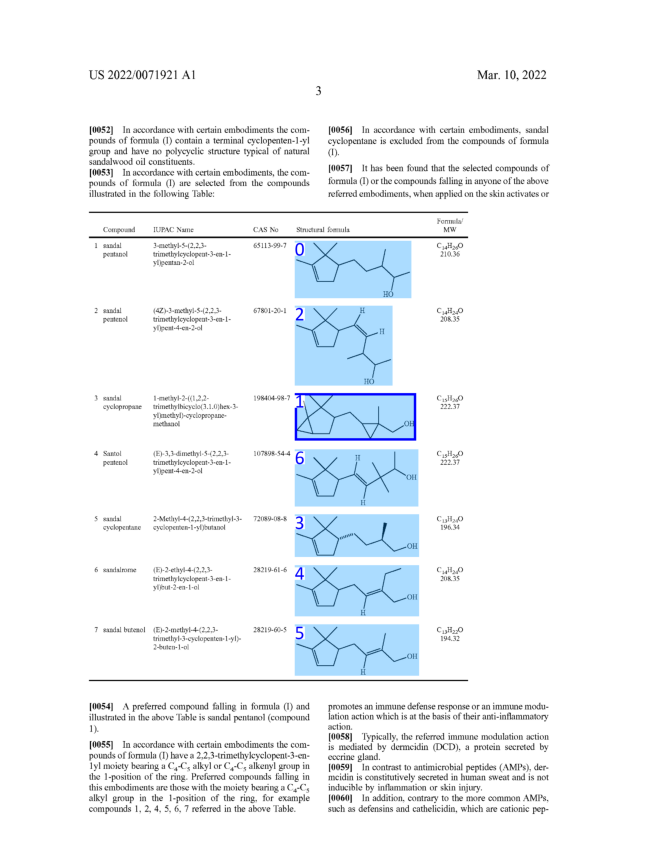

defaultdict(<class 'list'>, {'CC1(CO)CC1CC1CC2CC2(C)C1(C)C': [5]})


In [ ]:
if not(os.path.exists(os.getcwd() + f"/../data/pdfs/{query_patent}.pdf")):
    print(os.getcwd() + f"/../data/pdfs/{query_patent}.pdf not found. To display molecules locations, it is first needed to download the document .pdf on the patent office website.")

# Aromatize SMILES stored in "patent_entry" to allow string match comparison with "query_smiles"
new_figures = []
for figure in patent_entry["figures"]:
    new_figure = figure
    if (figure["class"] == "Clean") and ("smiles" in figure):
        molecule = Chem.MolFromSmiles(figure["smiles"]["value"])
        new_smiles = Chem.MolToSmiles(molecule, kekuleSmiles=False)
        new_figure["smiles"]["value"] = new_smiles    
    new_figures.append(new_figure)
patent_entry["figures"] = new_figures

# Get page index of query molecule 
smiles = query_smiles.replace("\[", "[").replace("\]", "]")
for figure in patent_entry["figures"]:
    if not("smiles" in figure):
        continue 
    if (figure["smiles"]["value"] == smiles):
        page_index = figure["page"]
        
# Convert pdf to page image
pages = convert_from_path(os.getcwd() + f"/../data/pdfs/{query_patent}.pdf", dpi=200, first_page=page_index, last_page=page_index)
pages = [None]*(page_index-1) + pages + [None]*(len(patent_entry["page-dimensions"])-page_index)

# Display page and molecules
display_molecules_locations(pages, patent_entry, max_pages_per_row=1, highlight_smiles_list=[smiles])